The project is using Diabetic Retinopathy Dataset located on [Kaggle](https://www.kaggle.com/datasets/sachinkumar413/diabetic-retinopathy-dataset/data) website. The dataset contains images of total 5 class labels and 2750 images in total.



In [1]:
# For a model training, Google Colab is used.
# For a data read, google drive mounting is used.

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# unzip data and save it in a folder 'retina_images'
! unzip /content/drive/MyDrive/ai_bootcamp_data/retina_images.zip -d retina_images

Archive:  /content/drive/MyDrive/ai_bootcamp_data/retina_images.zip
  inflating: retina_images/Healthy/Healthy.png  
  inflating: retina_images/Healthy/Healthy_10.png  
  inflating: retina_images/Healthy/Healthy_100.png  
  inflating: retina_images/Healthy/Healthy_1000.png  
  inflating: retina_images/Healthy/Healthy_101.png  
  inflating: retina_images/Healthy/Healthy_102.png  
  inflating: retina_images/Healthy/Healthy_103.png  
  inflating: retina_images/Healthy/Healthy_104.png  
  inflating: retina_images/Healthy/Healthy_105.png  
  inflating: retina_images/Healthy/Healthy_106.png  
  inflating: retina_images/Healthy/Healthy_107.png  
  inflating: retina_images/Healthy/Healthy_108.png  
  inflating: retina_images/Healthy/Healthy_109.png  
  inflating: retina_images/Healthy/Healthy_11.png  
  inflating: retina_images/Healthy/Healthy_110.png  
  inflating: retina_images/Healthy/Healthy_111.png  
  inflating: retina_images/Healthy/Healthy_112.png  
  inflating: retina_images/Healthy/H

In [3]:
# check number of files for each class
# create function to check number of files in a folder
import os

def count_files_in_folders(directory):
    # Dictionary to store the folder name and its file count
    folder_file_count = {}

    # Traverse the directory and its subdirectories
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)

        if os.path.isdir(folder_path):
            # List all files in the subfolder and count them
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_count[folder_name] = file_count

    return folder_file_count

# check existing folders
data_dir = 'retina_images'
file_counts = count_files_in_folders(data_dir)
for class_name, count in file_counts.items():
  print(f'Class "{class_name}" has {count} images.')

Class "Moderate DR" has 900 images.
Class "Severe DR" has 190 images.
Class "Proliferate DR" has 290 images.
Class "Mild DR" has 370 images.
Class "Healthy" has 1000 images.


Classes are imbalanced, kernel regularizer needs to be used to reduce bias.

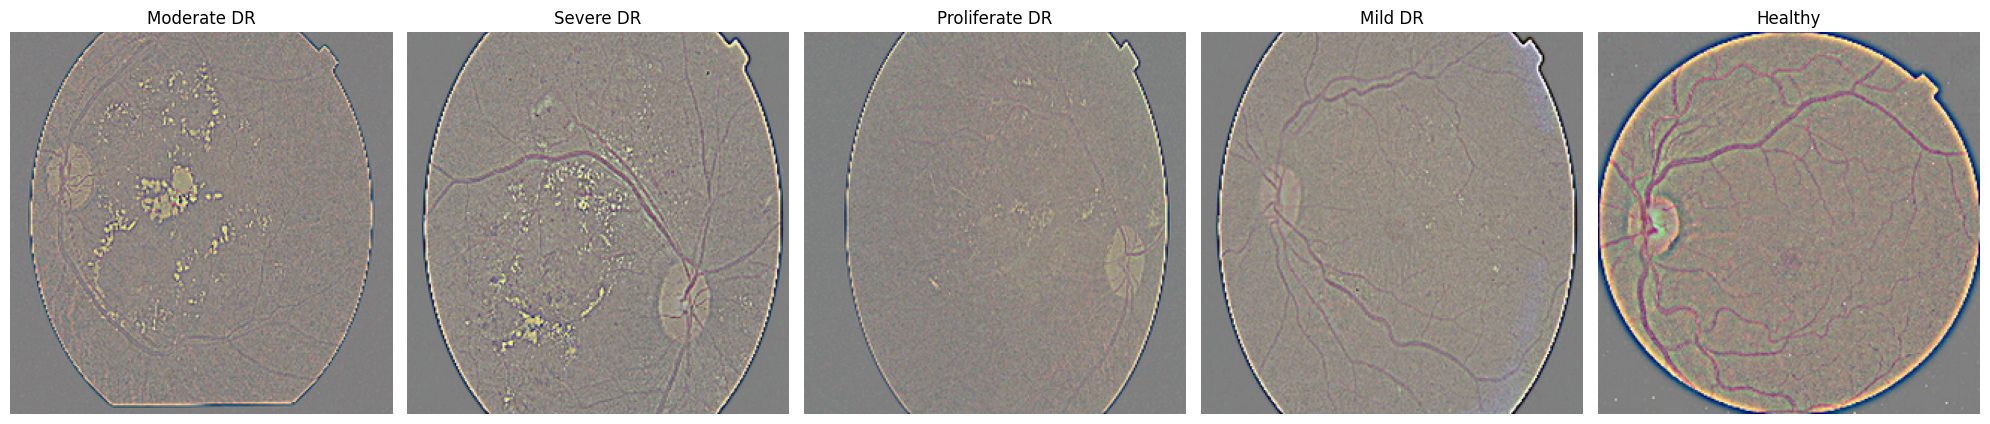

In [4]:
# vizualize sample data for each class

import os
import matplotlib.pyplot as plt
import cv2


# Create a list to store image paths and their corresponding folder names
image_list = []

# Walk through the root directory and its subdirectories
for subdir, _, files in os.walk(data_dir):
    folder_name = os.path.basename(subdir)
    for file in files[:1]:
        if file.lower().endswith(('.png')):
            image_list.append((os.path.join(subdir, file), folder_name))

# Plot the images
plt.figure(figsize=(20, 10))
for i, (img_path, folder_name) in enumerate(image_list):
  #print(img_path)
  plt.subplot(1, 5, i+1)
  img = cv2.imread(img_path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title(str(folder_name))

  plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
# create a function to check if images are over- or underexposed
import numpy as np

def is_overexposed_or_underexposed(image_path):
    # Open the image
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    pixel_values = np.array(image)

    # Calculate the brightness histogram
    histogram, bin_edges = np.histogram(pixel_values, bins=256, range=(0, 255))
    #print(histogram)
    # Define thresholds for exposure
    total_pixels = pixel_values.size
    overexposure_threshold = 0.07
    underexposure_threshold = 0.07

    # Check if overexposed (pixels close to 255)
    bright_pixel_percentage = np.sum(histogram[-20:]) / total_pixels  # top 20 brightness levels
    if bright_pixel_percentage > overexposure_threshold:
        return "overexposed"

    # Check if underexposed (pixels close to 0)
    dark_pixel_percentage = np.sum(histogram[:20]) / total_pixels  # bottom 20 brightness levels
    if dark_pixel_percentage > underexposure_threshold:
        return "underexposed"

    #return f"The image is well-exposed. Total pixels are {total_pixels}, bright pixels are {np.sum(histogram[-20:])}, and dark pixels are {np.sum(histogram[:20])}"

    return "well-exposed"

# check all images for exposure

# create a list of all image paths
image_list_all = []

# Walk through the root directory and its subdirectories
for subdir, _, files in os.walk(data_dir):
    folder_name = os.path.basename(subdir)
    for file in files:
        if file.lower().endswith(('.png')):
            image_list_all.append((os.path.join(subdir, file)))


# check images' exposure and print results
check_exposure = []
for image_path in image_list_all:
  exposure_check = is_overexposed_or_underexposed(image_path)

  check_exposure.append(exposure_check)
print(set(check_exposure))

{'well-exposed'}


Since none of image is not over- or underexposed, bypass image correction for it.

In [97]:
# create a function to remove image noise and normalize image pixels

def pre_process_image(img_path):
    """
    Reduce Noise and normalize an image.
    """
    # Read the image
    img = cv2.imread(img_path)



    #ret, thres4 = cv2.threshold(img, 125, 255, cv2.THRESH_TOZERO)

    # Remove image noise
    denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 2, 2, 5, 10)

    # Normalize pixel values to range [0, 1]
    final_img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return final_img

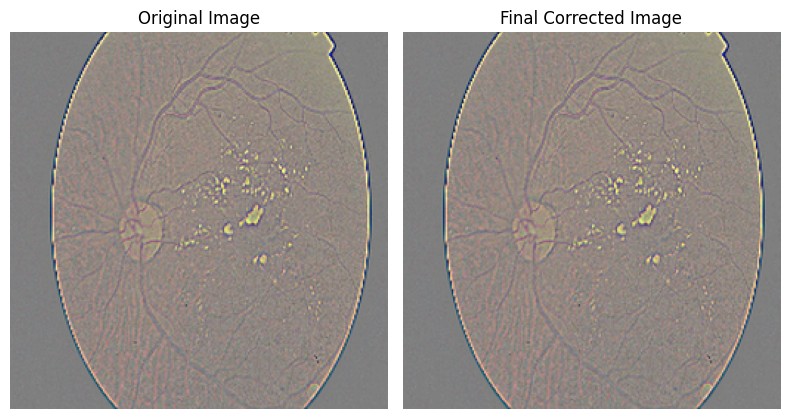

In [98]:
image_samle_path = '/content/retina_images/Moderate DR/Moderate_DR_120.png'
#image_samle_path = '/content/retina_images/Proliferate DR/Proliferate DR_110.png'

# Load the original image
original_img = cv2.imread(image_samle_path)

# pre-process the image
final_img = pre_process_image(image_samle_path)

# Show the results
plt.figure(figsize=(8, 8))
# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Show the overexposure corrected image
plt.subplot(1, 2,2)
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
#plt.imshow(final_img)
plt.title('Final Corrected Image')
plt.axis('off')

plt.tight_layout()
plt.show()


In [99]:
# preprocess all data
# create a function to preprocess all data
import numpy as np
from tqdm import tqdm  # For progress bar
def preprocess_dataset(data_dir):
    # Create lists to store images and labels (assuming labels are subfolder names)
    images = []
    labels = []
    class_names = os.listdir(data_dir)

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            print(f'Processing class: {class_name}')
            for img_name in tqdm(os.listdir(class_dir)):
                img_path = os.path.join(class_dir, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    processed_img = pre_process_image(img_path)
                    images.append(processed_img)
                    labels.append(class_name)

    # Convert lists to NumPy arrays for model training
    X = np.array(images)
    y = np.array(labels)

    return X, y

In [100]:
# Preprocess all images
data_dir = 'retina_images'

# Preprocess the dataset
X, y_labels = preprocess_dataset(data_dir)

print(f'Preprocessing complete! Data shape: {X.shape}, Labels shape: {y_labels.shape}')

Processing class: Moderate DR


100%|██████████| 900/900 [01:19<00:00, 11.28it/s]


Processing class: Severe DR


100%|██████████| 190/190 [00:16<00:00, 11.30it/s]


Processing class: Proliferate DR


100%|██████████| 290/290 [00:25<00:00, 11.27it/s]


Processing class: Mild DR


100%|██████████| 370/370 [00:32<00:00, 11.29it/s]


Processing class: Healthy


100%|██████████| 1000/1000 [01:28<00:00, 11.30it/s]


Preprocessing complete! Data shape: (2750, 256, 256, 3), Labels shape: (2750,)


In [101]:
# encode the labels
from sklearn.preprocessing import OneHotEncoder
import numpy as np


# Reshape the labels to be 2D array (required for OneHotEncoder)
labels = np.array(y_labels).reshape(-1, 1)

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the labels into one-hot encoded arrays
y = onehot_encoder.fit_transform(labels)

# Print the one-hot encoded array
print("One-Hot Encoded Array:\n", y)

One-Hot Encoded Array:
 [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [102]:
# split data into train, val, test
from sklearn.model_selection import train_test_split

# perform splitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# perform further splitting
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=123)

In [86]:
# data augmentation
# create a separate layer for a data augmentation
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  #layers.RandomZoom(0.2),
])

IMG_SIZE = 256

In [165]:
# create a model
from tensorflow.keras.regularizers import l1
from tensorflow.keras import layers

num_classes = len(set(y_labels))

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  tf.keras.Input((IMG_SIZE, IMG_SIZE, 3)),
  data_augmentation,
  layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding="same", kernel_regularizer=l1(0.01)
  ),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l1(0.01)
  ),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l1(0.01)
  ),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=l1(0.01)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=l1(0.01)),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.1),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_87               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_88               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_89               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 10,000,709 (38.15 MB)

 Trainable params: 9,999,813 (38.15 MB)

 Non-trainable params: 896 (3.50 KB)

In [166]:
# compile the model
from tensorflow.keras.optimizers import Adam

model.compile(
              optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Define the checkpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'checkpoints/model-{epoch:02d}-{val_loss:.2f}.weights.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,             # Path to save the model
    monitor='val_loss',                       # Monitor the validation loss
    save_best_only=True,                      # Save only the best weights (based on validation loss)
    save_weights_only=True,                   # Save only the model weights (not the full model)
    mode='min',                               # Save when 'val_loss' is minimized
    verbose=1,                                # Print messages when saving checkpoints
)

In [16]:
!pip install livelossplot

In [155]:
epochs = 50  # Number of epochs to train the model
batch_size = 128  # Batch size for training

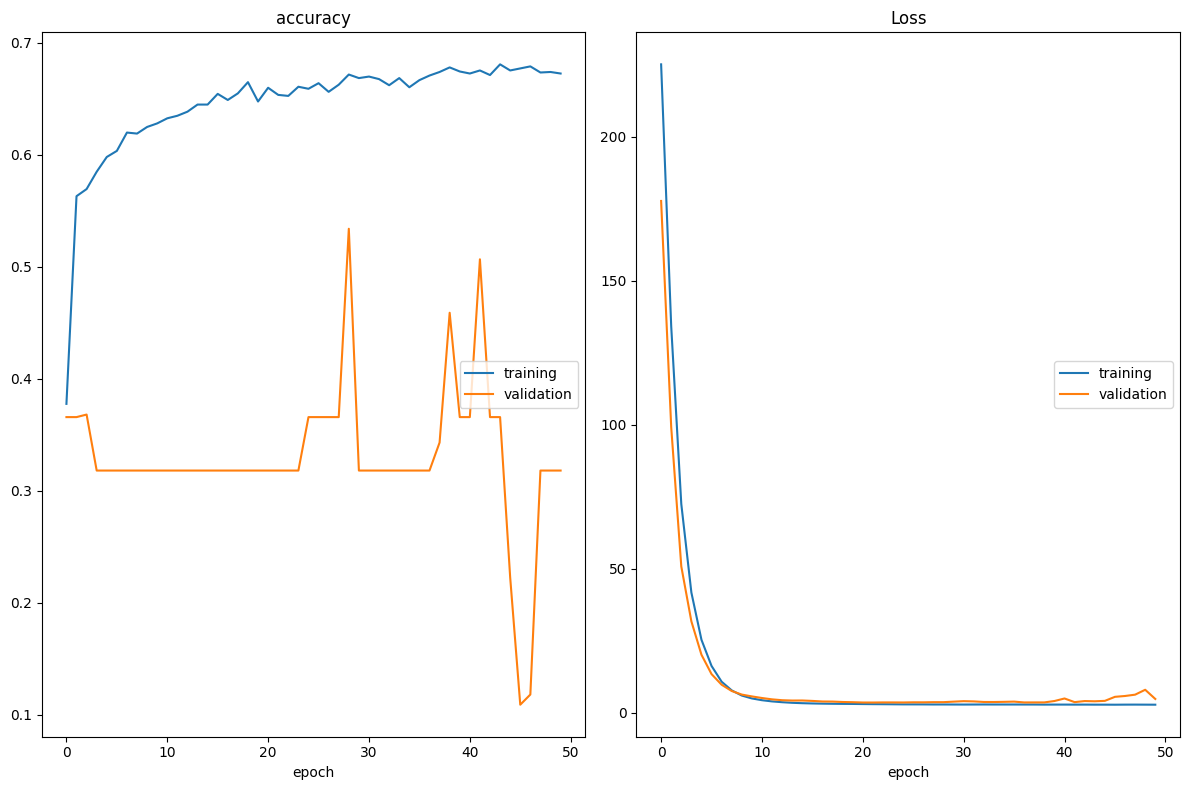

accuracy
	training         	 (min:    0.378, max:    0.681, cur:    0.673)
	validation       	 (min:    0.109, max:    0.534, cur:    0.318)
Loss
	training         	 (min:    2.832, max:  225.112, cur:    2.835)
	validation       	 (min:    3.588, max:  177.693, cur:    4.825)
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.6812 - loss: 2.8248 - val_accuracy: 0.3182 - val_loss: 4.8248


In [167]:
from livelossplot import PlotLossesKerasTF

# train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, PlotLossesKerasTF()]
)

In [168]:
# Evaluate Initial model on images and print loss and accuracy
initial_train_sc = model.evaluate(X_train, y_train, verbose = 1)
initial_valid_sc = model.evaluate(X_val, y_val, verbose = 1)
initial_test_sc = model.evaluate(X_test, y_test, verbose = 1)

# Print results
print(f"Inital Model Train Scores : \n    accuracy: {initial_train_sc[1]:.2f}, \n    loss:  {initial_train_sc[0]:.2f} \n________________________")

print(f"Inital Model Valid Scores : \n    accuracy: {initial_valid_sc[1]:.2f}, \n    loss:  {initial_valid_sc[0]:.2f} \n________________________")
print(f"Inital Model Test Scores : \n    accuracy: {initial_test_sc[1]:.3f}, \n    loss:  {initial_test_sc[0]:.2f} \n________________________")

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3239 - loss: 4.9576
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3455 - loss: 4.7381
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3496 - loss: 5.0792
Inital Model Train Scores : 
    accuracy: 0.33, 
    loss:  4.88 
________________________
Inital Model Valid Scores : 
    accuracy: 0.32, 
    loss:  4.82 
________________________
Inital Model Test Scores : 
    accuracy: 0.364, 
    loss:  5.11 
________________________


Initial model does not perform well and shows only 36% of accuracy.
Let's try transfer learning for better accuracy performance.

In [169]:
# import MobileNetV2 Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from livelossplot import PlotLossesKerasTF

# Load the MobileNetV2 model pre-trained on ImageNet, without the top (classification) layer

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the model
model_light = Sequential([
    tf.keras.Input((IMG_SIZE, IMG_SIZE, 3)),
    #data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')  # Number of classes
])

# Compile the model
model_light.compile(optimizer = Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_light.summary()

<ipython-input-169-0944568fed1a>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_19          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_90               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_91               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_92               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,629,189 (10.03 MB)

 Trainable params: 370,309 (1.41 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

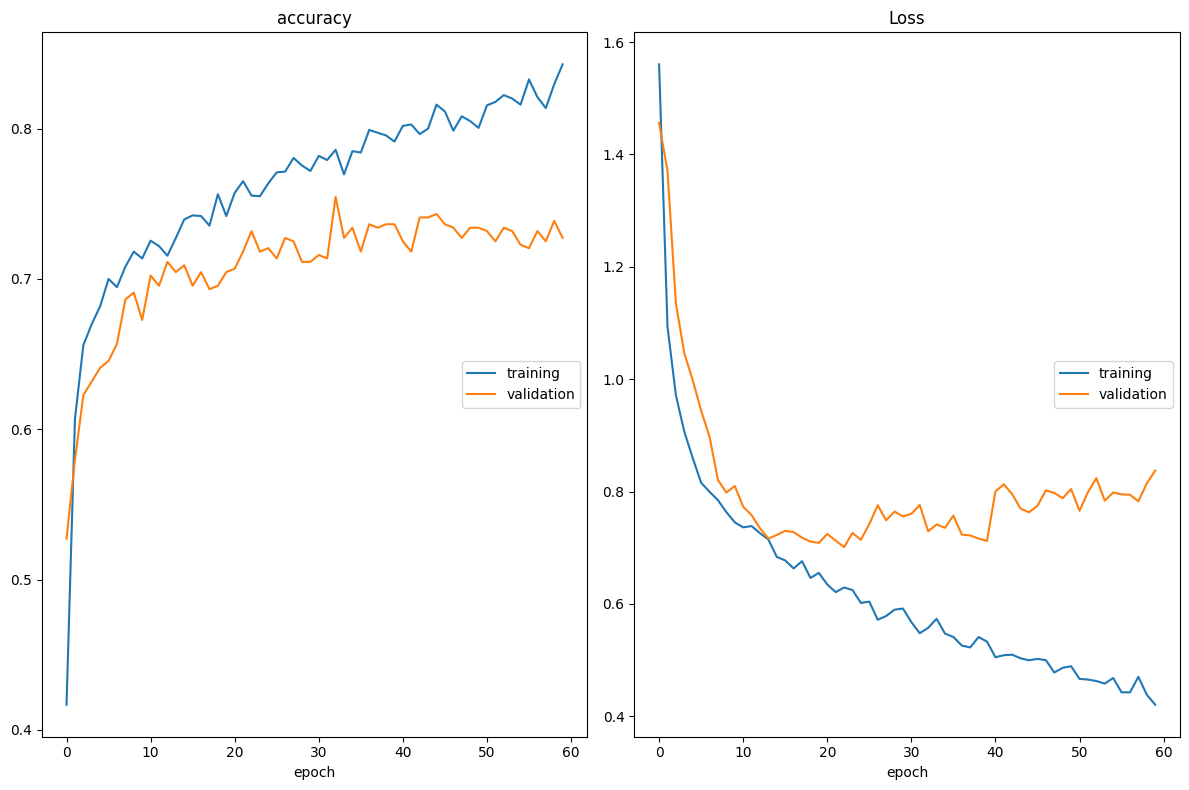

accuracy
	training         	 (min:    0.417, max:    0.843, cur:    0.843)
	validation       	 (min:    0.527, max:    0.755, cur:    0.727)
Loss
	training         	 (min:    0.421, max:    1.560, cur:    0.421)
	validation       	 (min:    0.701, max:    1.456, cur:    0.837)
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.8384 - loss: 0.4272 - val_accuracy: 0.7273 - val_loss: 0.8375


In [170]:
batch_size = 256
# Train the model
history_light = model_light.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=batch_size,
    callbacks=[checkpoint_callback, PlotLossesKerasTF()]
)

In [171]:
# Evaluate Transfered model on images and print loss and accuracy
transfer_train_sc = model_light.evaluate(X_train, y_train, verbose = 1)
transfer_valid_sc = model_light.evaluate(X_val, y_val, verbose = 1)
transfer_test_sc = model_light.evaluate(X_test, y_test, verbose = 1)

#Print
print(f"Transfer Learning Train Scores : \n    accuracy: {transfer_train_sc[1]:.2f}, \n    loss:  {transfer_train_sc[0]:.2f} \n________________________")

print(f"Transfer Learning Valid Scores : \n    accuracy: {transfer_valid_sc[1]:.2f}, \n    loss:  {transfer_valid_sc[0]:.2f} \n________________________")
print(f"Transfer Learning Test Scores : \n    accuracy: {transfer_test_sc[1]:.3f}, \n    loss:  {transfer_test_sc[0]:.2f} \n________________________")

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8816 - loss: 0.2856
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7644 - loss: 0.7565
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 543ms/step - accuracy: 0.6801 - loss: 0.9031
Transfer Learning Train Scores : 
    accuracy: 0.87, 
    loss:  0.30 
________________________
Transfer Learning Valid Scores : 
    accuracy: 0.73, 
    loss:  0.84 
________________________
Transfer Learning Test Scores : 
    accuracy: 0.645, 
    loss:  1.04 
________________________


In [172]:
# Make Directory to save the model
VERSION = 1
!mkdir -p /content/saved_models/retina_images/{VERSION}

In [173]:

# Create the artifact for the model
# For Tensoflow Serving, save model in an appropriate format
model_light.export("saved_models/retina_images/1/")

Saved artifact at 'saved_models/retina_images/1/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_5753')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134451231750128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134452234008912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134462437722240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134462438160544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134462357627728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134462357622800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134451421689136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134451402145312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134451421676640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134451421686672: TensorSpec(shape=(), dtype=tf.resource, name=None

In [174]:
# Prepare variabes for Google Colab and Tensoflow Serving connection
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [175]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0  18677      0 --:--:-- --:--:-- --:--:-- 18745
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [

In [176]:
# Install Tensoflow Serving API
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.17.0/t/tensorflow-model-server/tensorflow-model-server_2.17.0_all.deb'
!dpkg -i tensorflow-model-server_2.17.0_all.deb
#!pip3 install tensorflow-serving-api==2.17.0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 52 not upgraded.
Need to get 615 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.17.0 [615 MB]
Fetched 615 MB in 5s (124 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.17.0_all.deb ...
Unpacking tensorflow-model-server (2.17.0) ...
Setting up tensorflow-model-server (2.17.0) ...
--2024-10-16 15:51:13--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.17.0/t/tensorflow-model-server/tensorflow-model-server_2.17.0_all.deb
Resolving storage.g

In [177]:
# create model directory variable to be used in a Tensoflow Serving
MODEL_DIR = '/content/saved_models/retina_images'
os.environ["MODEL_DIR"] = MODEL_DIR

In [178]:
# Start the server
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=retina_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [179]:
# check logs

! tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 250] NET_LOG: Entering the event loop ...


In [180]:
# Make a request on a sampe data
!pip install -q requests

import requests
#headers = {"content-type": "application/json"}

# Sample data (replace with actual input shape)
input_data = {
    "instances": X_test[0:3].tolist()
}

request_link = 'http://localhost:8501/v1/models/retina_model:predict'

# Send the request
response = requests.post(request_link, json=input_data)
# Print the response
print(response.json())

{'predictions': [[0.00240398571, 0.0112892017, 0.953656673, 0.0250984821, 0.00755168963], [0.00185001292, 0.0601063073, 0.818333507, 0.0846957713, 0.0350144617], [1.17675754e-05, 0.000151385902, 0.687759936, 0.00169657636, 0.31038031]]}


In [188]:
import json
# check prediction results

# create a list of classes
class_names = os.listdir(data_dir)

# save predictions in a separate variable
predictions = response.json()['predictions']

# Invert true encoded Labels to a category for the sampe data
y_true = onehot_encoder.inverse_transform(y_test[0:3])

In [215]:
# print true values and predicted
print(f" First Image:\n\n  True value : {y_true[0][0]}\n  Predicted value: {class_names[np.argmax(predictions[0])]}\n____________________")
print(f" Second Image:\n\n  True value : {y_true[1][0]}\n  Predicted value: {class_names[np.argmax(predictions[1])]}\n____________________")
print(f" Third Image:\n\n  True value : {y_true[2][0]}\n  Predicted value: {class_names[np.argmax(predictions[2])]}\n____________________")

 First Image:

  True value : Moderate DR
  Predicted value: Proliferate DR
____________________
 Second Image:

  True value : Moderate DR
  Predicted value: Proliferate DR
____________________
 Third Image:

  True value : Severe DR
  Predicted value: Proliferate DR
____________________
